<a href="https://colab.research.google.com/github/lichouinard/aidi1002_project/blob/main/intentRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction:

For intent recognition in NLP, we can use machine learning models to classify user inputs into predefined intents. Here we will use a neural network model to build and train a simple intent recognition model using TensorFlow and Keras.

### Import all the necessary libraries and functions:

In [33]:
import json
import numpy as np
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, GRU, LSTM
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
from transformers import BertConfig, AutoTokenizer, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt

2.15.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Prepare the Dataset
This model uses intent classification dataset from Kaggle:
https://www.kaggle.com/datasets/stefanlarson/outofscope-intent-classification-dataset/data

Content

  is_train.json,is_val.json, is_test.json: these files house the train/val/test sets for the in-scope data. There are 150 in-scope "intents" (aka classes), which include samples such as "what is my balance" (which belongs to the balance class).

  oos_test.json:test sets for the out-of-scope data. There is one out-of-scope intent: oos

In [5]:
import io
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving is_test.json to is_test.json
Saving is_train.json to is_train.json
Saving is_val.json to is_val.json
Saving oos_test.json to oos_test.json
Saving oos_train.json to oos_train.json
Saving oos_val.json to oos_val.json


In [7]:
PATH_TO_TRAIN_DS = "/content/is_train.json"
PATH_TO_VALID_DS = "/content/is_val.json"
PATH_TO_TEST_DS = "/content/is_test.json"
PATH_TO_OOS_DATA = "/content/oos_test.json"

tf.random.set_seed(42)

In [8]:
train = np.array(json.load(open(PATH_TO_TRAIN_DS, 'r')))
val = np.array(json.load(open(PATH_TO_VALID_DS, 'r')))
test = np.array(json.load(open(PATH_TO_TEST_DS, 'r')))
oos = np.array(json.load(open(PATH_TO_OOS_DATA, 'r')))

In [9]:
train[:,1]

array(['translate', 'translate', 'translate', ..., 'card_declined',
       'card_declined', 'card_declined'], dtype='<U136')

In [10]:
data_train = pd.DataFrame({
    'text' : train[:,0],
    'label': train[:,1]
})
data_val = pd.DataFrame({
    'text' : val[:,0],
    'label': val[:,1]
})
data_test = pd.DataFrame({
    'text' : test[:,0],
    'label': test[:,1]
})

In [11]:
data_val["text"]

0                in spanish, meet me tomorrow is said how
1                  in french, how do i say, see you later
2                        how do you say hello in japanese
3               how do i ask about the weather in chinese
4               how can i say "cancel my order" in french
                              ...                        
2995    i was at walmart trying to buy toilet paper an...
2996         target declined my card and i don't know why
2997    do you know why my card was declined at target...
2998    i can't figure out why my card was declined at...
2999    i was just at target and they declined my card...
Name: text, Length: 3000, dtype: object

In [14]:
labels = np.sort(np.unique(train[:,1]))
label_to_id = {label:i for i,label in enumerate(labels)}
id_to_label = {i:label for i,label in enumerate(labels)}
num_classes = len(labels)
print(f"Number of classes: {num_classes}")

Number of classes: 150


In [15]:
id_to_label[np.random.randint(150)]

'change_speed'

Tokenize the text patterns and pad the sequences to ensure uniform input shape.

Encode the intent labels and convert them to categorical one-hot encoding.

In [37]:
# text processing
from keras.utils import to_categorical
tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")
tokenizer.fit_on_texts(data_train['text'])
sequences = tokenizer.texts_to_sequences(data_train['text'])
max_length = 28
train_sequences = pad_sequences(sequences, padding='post', maxlen=max_length)


# Encode labels into integer numeric values
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(data_train['label'])

# Convert encoded labels to one-hot encoding
train_labels = to_categorical(train_labels_encoded, num_classes)

In [20]:
sequences_val = tokenizer.texts_to_sequences(data_val['text'])
val_sequences = pad_sequences(sequences_val, padding='post', maxlen=max_length)

val_labels_encoded = label_encoder.transform(data_val['label'])
val_labels = to_categorical(val_labels_encoded, num_classes)

sequences_test = tokenizer.texts_to_sequences(data_test['text'])
test_sequences = pad_sequences(sequences_test, padding='post',maxlen=max_length)

test_labels_encoded = label_encoder.transform(data_test['label'])
test_labels = to_categorical(test_labels_encoded, num_classes)

In [38]:
len(sequences_val)

3000

In [39]:
len(train_labels), train_labels.shape

(15000, (15000, 150))

In [40]:
#Adjust the shape of training and validation labels
train_labels = np.reshape(train_labels, (len(train_labels), 150))
val_labels = np.reshape(val_labels, (len(val_labels), 150))
test_labels = np.reshape(test_labels, (len(test_labels), 150))

In [41]:
val_sequences.shape, val_labels.shape,test_sequences.shape, test_labels.shape,

((3000, 28), (3000, 150), (4500, 28), (4500, 150))

In [42]:
word_index = tokenizer.word_index
vocab_size = len(word_index) +1
max_sequence_length = max(len(sequence) for sequence in train_sequences)
embedding_dim = min(100, vocab_size // 2)

In [26]:
max(len(sequence) for sequence in val_sequences)

28

In [27]:
val_sequences.shape, val_labels.shape,

((3000, 28), (3000, 150))

### Evaluation Metrics

In [28]:
def graph_history(history):

    # Get training and validation metrics from history
    training_loss = history.history['loss']
    validation_loss =history.history['val_loss']
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Create a Pandas DataFrame with training and validation metrics
    history_df = pd.DataFrame({
        'Training Loss': training_loss,
        'Validation Loss': validation_loss,
        'Training Accuracy': training_accuracy,
        'Validation Accuracy': validation_accuracy
    })

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(history_df['Training Loss'], label='Training Loss')
    plt.plot(history_df['Validation Loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot precision curves (accuracy)
    plt.figure(figsize=(10, 6))
    plt.plot(history_df['Training Accuracy'], label='Training Accuracy')
    plt.plot(history_df['Validation Accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

## Build models

**RNN**

Epoch 1/15
469/469 [==============================] - 15s 24ms/step - loss: 4.0920 - accuracy: 0.1091 - val_loss: 3.4140 - val_accuracy: 0.2140
Epoch 2/15
469/469 [==============================] - 12s 25ms/step - loss: 2.7900 - accuracy: 0.3357 - val_loss: 2.7137 - val_accuracy: 0.3677
Epoch 3/15
469/469 [==============================] - 12s 25ms/step - loss: 2.1292 - accuracy: 0.4717 - val_loss: 2.3523 - val_accuracy: 0.4587
Epoch 4/15
469/469 [==============================] - 12s 25ms/step - loss: 1.6630 - accuracy: 0.5857 - val_loss: 2.2038 - val_accuracy: 0.4823
Epoch 5/15
469/469 [==============================] - 11s 24ms/step - loss: 1.3625 - accuracy: 0.6600 - val_loss: 2.0732 - val_accuracy: 0.5370
Epoch 6/15
469/469 [==============================] - 11s 24ms/step - loss: 1.1957 - accuracy: 0.6951 - val_loss: 2.0076 - val_accuracy: 0.5460
Epoch 7/15
469/469 [==============================] - 25s 52ms/step - loss: 1.0025 - accuracy: 0.7463 - val_loss: 2.1047 - val_accuracy:

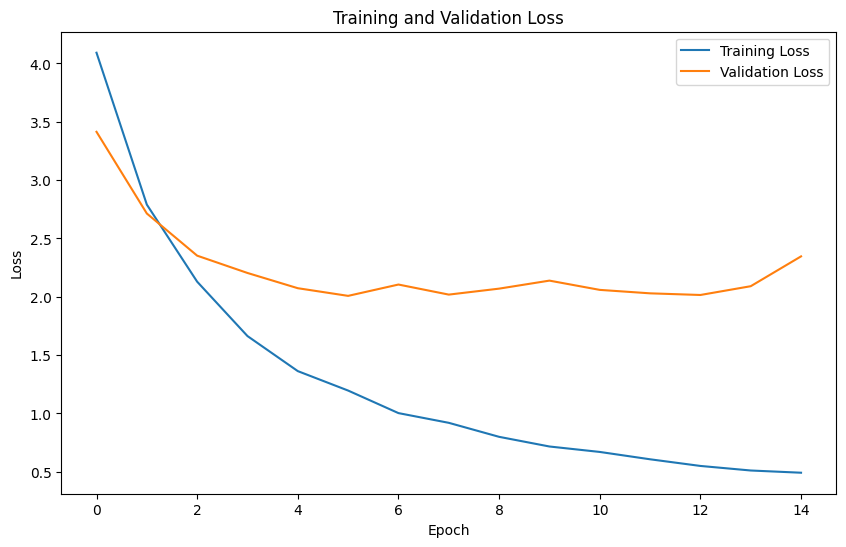

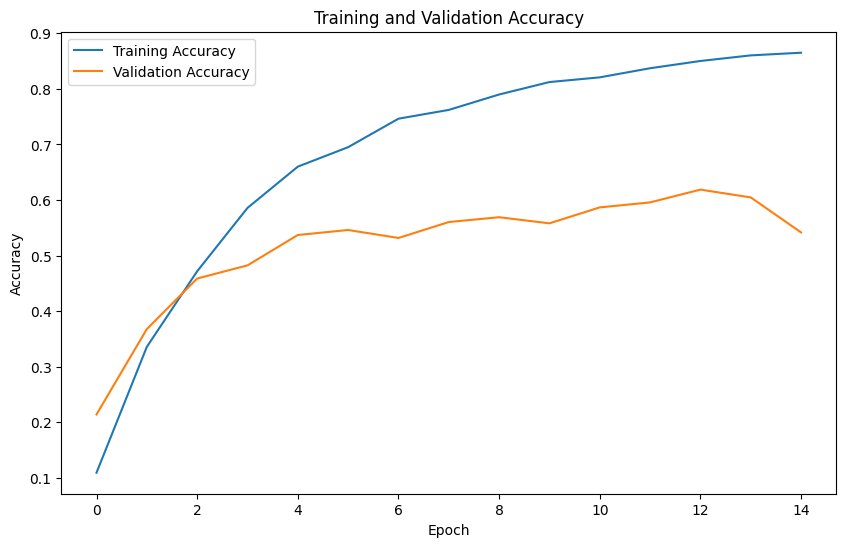

In [31]:
# Define the recurrent neural network model
model_RNN = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    SimpleRNN(128, input_shape=(train_sequences.shape[1], 1)),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_RNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history_RNN = model_RNN.fit(train_sequences, train_labels, epochs=15, validation_data=(val_sequences, val_labels))

# Evaluate model performance on the test set
loss, accuracy = model_RNN.evaluate(test_sequences, test_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')
graph_history(history_RNN)

**GRU**

Epoch 1/15
469/469 [==============================] - 31s 53ms/step - loss: 5.0135 - accuracy: 0.0061 - val_loss: 5.0116 - val_accuracy: 0.0067
Epoch 2/15
469/469 [==============================] - 21s 46ms/step - loss: 5.0081 - accuracy: 0.0074 - val_loss: 4.8464 - val_accuracy: 0.0157
Epoch 3/15
469/469 [==============================] - 24s 52ms/step - loss: 3.3660 - accuracy: 0.1606 - val_loss: 2.5552 - val_accuracy: 0.3367
Epoch 4/15
469/469 [==============================] - 25s 54ms/step - loss: 1.8071 - accuracy: 0.5097 - val_loss: 1.7683 - val_accuracy: 0.5657
Epoch 5/15
469/469 [==============================] - 25s 54ms/step - loss: 1.1218 - accuracy: 0.7085 - val_loss: 1.5196 - val_accuracy: 0.6413
Epoch 6/15
469/469 [==============================] - 26s 55ms/step - loss: 0.7827 - accuracy: 0.8002 - val_loss: 1.4426 - val_accuracy: 0.6817
Epoch 7/15
469/469 [==============================] - 22s 47ms/step - loss: 0.5851 - accuracy: 0.8513 - val_loss: 1.3738 - val_accuracy:

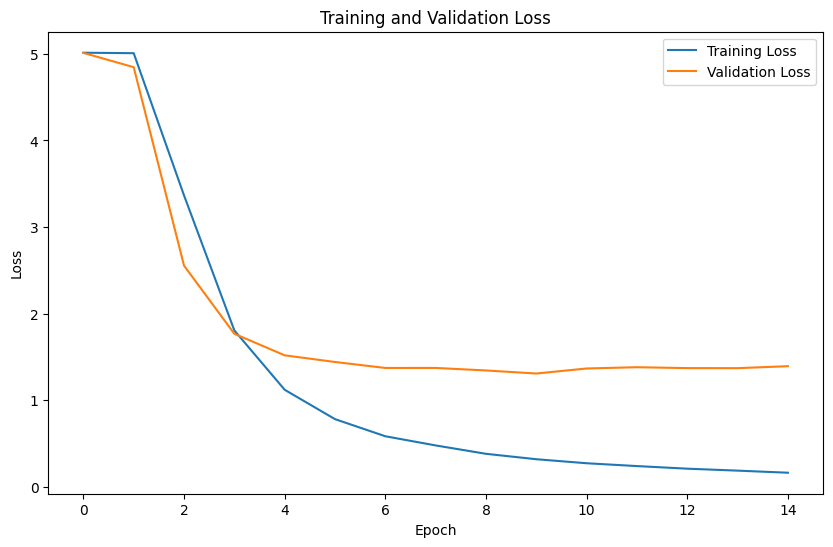

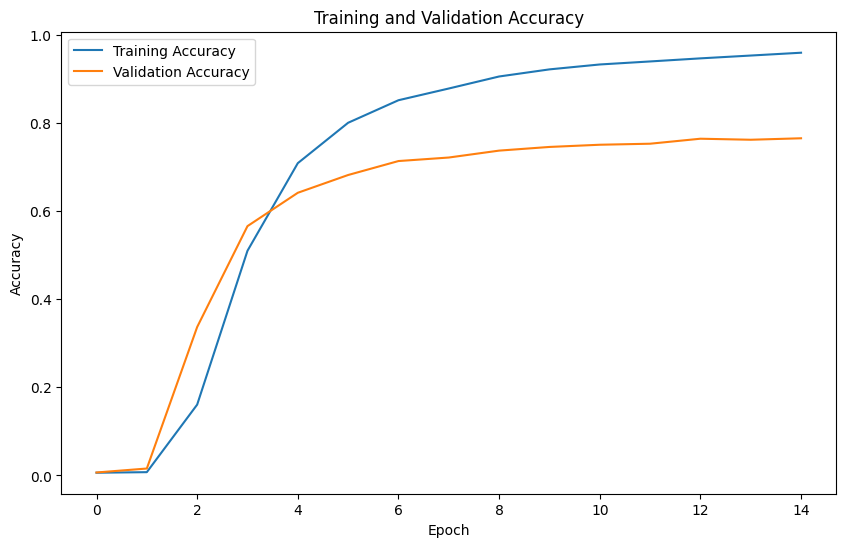

In [34]:
# Define the recurrent neural network model
model_GRU = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    GRU(128, input_shape=(train_sequences.shape[1], 1)),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_GRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history_GRU = model_GRU.fit(train_sequences, train_labels, epochs=15, validation_data=(val_sequences, val_labels))

#Evaluate model performance on the test set
loss, accuracy = model_GRU.evaluate(test_sequences, test_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')
graph_history(history_GRU)

**LSTM**

Epoch 1/30
469/469 [==============================] - 39s 73ms/step - loss: 4.5281 - accuracy: 0.0248 - val_loss: 3.7881 - val_accuracy: 0.0490
Epoch 2/30
469/469 [==============================] - 32s 69ms/step - loss: 3.2383 - accuracy: 0.1111 - val_loss: 2.9584 - val_accuracy: 0.1690
Epoch 3/30
469/469 [==============================] - 33s 70ms/step - loss: 2.4593 - accuracy: 0.2619 - val_loss: 2.3455 - val_accuracy: 0.3213
Epoch 4/30
469/469 [==============================] - 38s 80ms/step - loss: 1.7400 - accuracy: 0.4693 - val_loss: 1.8808 - val_accuracy: 0.4723
Epoch 5/30
469/469 [==============================] - 34s 73ms/step - loss: 1.2126 - accuracy: 0.6335 - val_loss: 1.5010 - val_accuracy: 0.6170
Epoch 6/30
469/469 [==============================] - 33s 71ms/step - loss: 0.8608 - accuracy: 0.7526 - val_loss: 1.3901 - val_accuracy: 0.6597
Epoch 7/30
469/469 [==============================] - 34s 73ms/step - loss: 0.6459 - accuracy: 0.8217 - val_loss: 1.2353 - val_accuracy:

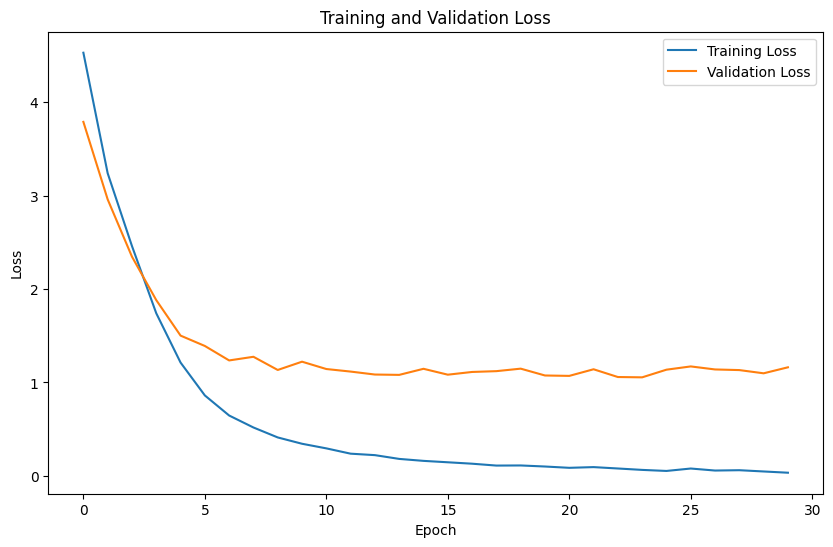

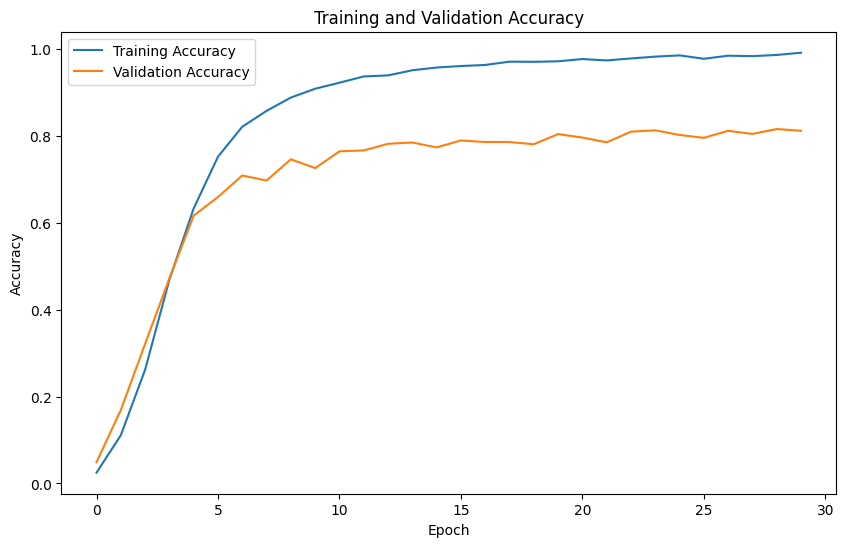

In [36]:
# Define the recurrent neural network model
model_LSTM = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(128, input_shape=(train_sequences.shape[1], 1)),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history_LSTM = model_LSTM.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels))

# Evaluate model performance on the test set
loss, accuracy = model_LSTM.evaluate(test_sequences, test_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')
graph_history(history_LSTM)

## Analyze parameters impacts

In a machine learning model for intent recognition, various parameters can significantly impact the model's performance and output. Here are some of the key parameters and their effects:

1.   Vocabulary Size

*   Parameter: num_words in Tokenizer
*   Impact: Determines the maximum number of unique words to keep, based on word frequency. A larger vocabulary can capture more details but may also include noise, while a smaller vocabulary might miss important words

2. Out-of-Vocabulary Token

* Parameter: oov_token in Tokenizer
* Impact: Helps handle words that are not in the training vocabulary. This is crucial for dealing with real-world data where users might use unexpected words.

3. Sequence Length

* Parameter: maxlen in pad_sequences
* Impact: Defines the length to which all sequences are padded or truncated. Longer sequences can capture more context but may also increase computational complexity. Shorter sequences might lose important information.

4. RNN models
  * a.  Embedding layer Parameters:
   *- input_dim: Larger vocabularies capture more details but increase complexity.
   *- output_dim: Higher dimensions can capture more information but risk overfitting.
   *- input_length: Must match the length of input sequences, affects tensor shape.    
 * b. SimpleRNN Layer parameters
   *- units: More units can learn more complex patterns but increase computational cost.
 * c. Dense Layer parameters
   *- units: Should match the number of classes in the classification problem.
   *- activation: Softmax is suitable for multi-class classification. We can also use relu activation function.ReLU is typically used in the hidden layers of a neural network to add non-linearity.
  * d. Optimizer:
   *- Adam (Adaptive Moment Estimation)
    *- Pros: Adaptive learning rates, momentum, efficient, less parameter tuning.
    *- Cons: May not be optimal for all types of problems; tuning learning rate might still be necessary in some cases.
   *- RMSProp (Root Mean Square Propagation)
    *- Pros: Works well for RNNs, particularly on problems with lots of noisy data.
    *- Cons: Requires tuning of the learning rate.
  * e. Loss Function: categorical_crossentropy
   *- Pros: Suitable for multi-class classification, provides a probabilistic interpretation.
   *- Cons:Sensitive to class imbalance; may need adjustments like class weights or data resampling.
  * f. Metrics: ['accuracy']
   *- Pros:Easy to interpret, suitable for balanced datasets.
   *- Cons:May not provide a complete picture for imbalanced datasets; additional metrics might be needed.

SimpleRNN vs GRU vs LSTM

1. SimpleRNN
* Architecture:
 * The basic form of an RNN.
 * Each unit has a hidden state that is updated at each time step.
 * Uses the hidden state from the previous time step to influence the current state.
* Pros:
 * Simpler and computationally less expensive compared to GRU and LSTM.
 * Easier to implement and understand.
 * Suitable for problems with short-term dependencies.
* Cons:
 * Struggles with learning long-term dependencies due to the vanishing gradient problem.
 * Limited memory capacity.
2. GRU (Gated Recurrent Unit)
* Architecture:
 * Introduced to address the limitations of SimpleRNN.
Combines the hidden state and cell state into a single state.
 * Uses gating mechanisms (reset gate and update gate) to control the flow of information.
* Pros:
 * Addresses the vanishing gradient problem better than SimpleRNN.
 * More efficient than LSTM due to fewer parameters.
 * Often performs well on a variety of tasks.
* Cons:
 * More complex and computationally expensive than SimpleRNN.
 * Slightly less expressive than LSTM due to fewer gates.
3. LSTM (Long Short-Term Memory)
* Architecture:
 * Designed to address both the vanishing and exploding gradient problems.
 * Maintains a separate cell state in addition to the hidden state.
 * Uses three gates: input gate, forget gate, and output gate to regulate information flow.
* Pros:
 * Excellent at learning long-term dependencies.
 * More expressive and powerful due to its gating mechanisms.
 * Widely used and proven effective in many sequential tasks like text generation, machine translation, etc.
* Cons:
 * More complex and computationally expensive due to a larger number of parameters.
 * Slower to train compared to SimpleRNN and GRU.